# Texture Synthesis with Spatial Generative Adversarial Networks

[Paper](https://arxiv.org/pdf/1611.08207v2.pdf)
[Sample implementation](https://github.com/ubergmann/spatial_gan)


In [1]:
import tensorflow as tf
import numpy as np
from nbutil import imshow_multi, to_pil
from tensorflow.contrib.layers.python.layers import batch_norm
from tensorflow.contrib.layers import xavier_initializer
import skimage
import skimage.io

In [2]:
BATCH_SIZE = 16
OUTPUT_WIDTH, OUTPUT_HEIGHT = (256, 256)
R = 16
Z_WIDTH, Z_HEIGHT = (OUTPUT_WIDTH / R, OUTPUT_HEIGHT / R)
Z_DEPTH = 32
N_DISCRIMINATORS = 1

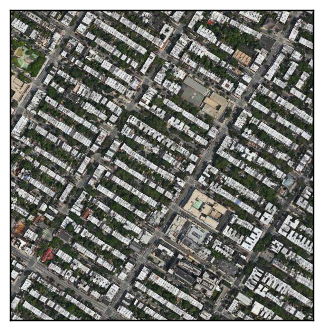

In [3]:
%matplotlib inline

def load_image(path):
    # load image
    img = skimage.io.imread(path)
    img = img[:,:,:3] # drop alpha channel
    return img / 255.0

image = load_image('../data/bk.png')
imshow_multi([image])


In [4]:
dropout_keep_prob = tf.placeholder_with_default(tf.constant(1.0), [], name='dropout_keep_prob')        

def lrelu(x):
    alpha = 0.05
    return tf.maximum(alpha*x, x)

def concat_elu(x):
    """ like concatenated ReLU (http://arxiv.org/abs/1603.05201), but then with ELU """
    axis = len(x.get_shape())-1
    return tf.nn.elu(tf.concat(axis, [x, -x]))

def create_batch_norm(inputs, name='bn'):
    with tf.variable_scope(name):
        return batch_norm(inputs, is_training=True, updates_collections=None)

def create_dropout(inputs):
    return tf.nn.dropout(inputs, dropout_keep_prob)

def create_conv(input, out_channels, patch_size=5, stride=1, use_relu=True, name='conv'):
    with tf.variable_scope(name):
        in_channels = input.get_shape()[-1].value
        # w = weight_var([patch_size, patch_size, in_channels, out_channels], name='w', key=join_keys(key, 'w'))
        # b = weight_var([out_channels], stddev=0, name='b', mean=0.1, key=join_keys(key, 'b'))
        w = tf.get_variable('w', 
                            shape=[patch_size, patch_size, in_channels, out_channels], 
                            initializer=xavier_initializer())
        b = tf.get_variable('b',
                           shape=[out_channels])
        conv = tf.nn.conv2d(input, w, strides=[1,stride,stride,1], padding='SAME')
        activation = concat_elu(conv + b) if use_relu else conv + b
        return activation

def create_deconv(input, out_channels, patch_size=5, stride=1, use_relu=True, name='deconv'):
    with tf.variable_scope(name):
        # for best results, patch_size should be a multiple of stride
        input_w, input_h, input_channels = [i.value for i in input.get_shape()[-3:]]

        # w = weight_var([patch_size, patch_size, out_channels, input_channels])
        # b = weight_var([out_channels], mean=0.1)
        w = tf.get_variable('w', 
                            shape=[patch_size, patch_size, out_channels, input_channels], 
                            initializer=xavier_initializer())
        b = tf.get_variable('b',
                            shape=[out_channels])

        batch_size = BATCH_SIZE # tf.shape(input)[0]
        output_shape = tf.pack([batch_size, input_w*stride, input_h*stride, out_channels])

        deconv = tf.nn.conv2d_transpose(input, w, output_shape, strides=[1,stride,stride,1], padding='SAME')

        activation = concat_elu(deconv + b) if use_relu else deconv + b
        return activation


In [5]:
source_image = tf.constant(image, tf.float32)
def rand_crop(): return tf.random_crop(source_image, [OUTPUT_WIDTH, OUTPUT_HEIGHT, 3])
real_textures = [rand_crop() for _ in xrange(BATCH_SIZE)]

def generator(noise):
    with tf.variable_scope('generator'):
        image = noise
        # strides must multiply to R (16)
        layers = [128, 64, 32, 3]
        for i, channels in enumerate(layers):
            is_last_layer = i == len(layers)-1
            image = create_deconv(image, 
                                  channels, 
                                  patch_size=5, 
                                  stride=2, 
                                  name='deconv'+str(i), 
                                  use_relu=(not is_last_layer))
            if not is_last_layer:
                image = create_batch_norm(image, name='bn'+str(i))
        assert [d.value for d in image.get_shape()[1:]] == [OUTPUT_WIDTH, OUTPUT_HEIGHT, 3]
        image = tf.sigmoid(image)
        return image

def discriminator(textures, name):
    # input: [BATCH_SIZE, IMAGE_WIDTH, IMAGE_HEIGHT, 3] textures
    # output: [BATCH_SIZE, Z_WIDTH, Z_HEIGHT, 2]
    #  where the last dim is the logit probability of this texture being real
    with tf.variable_scope(name):
        image = textures
        # some big convolutional layers:
        layers = [128, 64, 32, 2]
        for i, channels in enumerate(layers):
            is_last_layer = i == len(layers) - 1
            image = create_conv(image, channels, stride=2, patch_size=5, name='conv'+str(i), use_relu=(not is_last_layer))
            # image = create_avg_pool(image)
            if not is_last_layer:
                image = create_batch_norm(image, name='bn'+str(i))
                image = create_dropout(image)
        # a couple 1x1 convolutions:
        # for i, channels in enumerate([2]):
        #     image = create_conv(image, channels, stride=1, patch_size=1, name='1x1conv'+str(i))
        assert [d.value for d in image.get_shape()[1:]] == [Z_WIDTH, Z_HEIGHT, 2]
        return image

def compute_disc_output_accuracy(output, target):
    disc_guess = tf.argmax(output, 3)
    disc_correct = tf.equal(tf.cast(disc_guess, tf.int32), target)
    disc_accuracy = tf.reduce_mean(tf.cast(disc_correct, tf.float32))
    return disc_accuracy

def compute_disc_loss(output, target):
    targets = tf.one_hot(target, depth=2, on_value=0.9)
    return tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(output, targets))
    # return tf.reduce_sum(tf.nn.sparse_softmax_cross_entropy_with_logits(output, target))

scopename = '2'

disc_lr = tf.placeholder_with_default(tf.constant(0.0001), [], name='disc_lr')
gen_lr = tf.placeholder_with_default(tf.constant(0.0002), [], name='gen_lr')

def make_disc_train_op(name, loss):
    disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scopename+'/'+name)
    global_step = tf.contrib.framework.get_or_create_global_step()
    return tf.train.AdamOptimizer(disc_lr, beta1=0.5).minimize(loss, global_step=global_step, var_list=disc_vars)

with tf.variable_scope(scopename):

    noise = tf.random_uniform([BATCH_SIZE, Z_WIDTH, Z_HEIGHT, Z_DEPTH], minval=-1, maxval=1)
    synthetic_textures = generator(noise)

    disc_input = tf.concat(0, [real_textures, synthetic_textures])
    disc_target = tf.concat(0, [tf.ones([BATCH_SIZE, Z_WIDTH, Z_HEIGHT], tf.int32), tf.zeros([BATCH_SIZE, Z_WIDTH, Z_HEIGHT], tf.int32)])
    
    disc_names = ['disc' + str(i) for i in range(N_DISCRIMINATORS)]
    disc_outputs = [discriminator(disc_input, name) for name in disc_names]
    disc_losses = [compute_disc_loss(output, disc_target) for output in disc_outputs]
    disc_accuracies = [compute_disc_output_accuracy(output, disc_target) for output in disc_outputs]
    total_loss = tf.add_n(disc_losses)
    total_acc = tf.add_n(disc_accuracies) / N_DISCRIMINATORS
    disc_train_ops = [make_disc_train_op(name, loss) for name, loss in zip(disc_names, disc_losses)]

    gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scopename+'/generator')
    global_step = tf.contrib.framework.get_or_create_global_step()
    train_gen = tf.train.AdamOptimizer(gen_lr, beta1=0.5).minimize(-total_loss, global_step=global_step, var_list=gen_vars)


In [6]:
session = tf.InteractiveSession()

save_path = 'models/sgan256-4-3'

init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
session.run(init_op)

import os
saver = None
if save_path:
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(save_path)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(session, ckpt.model_checkpoint_path)
        print 'Restored from checkpoint', ckpt.model_checkpoint_path
    else:
        print 'Did not restore from checkpoint'
else:
    print 'Will not save progress'

Did not restore from checkpoint


In [7]:
def avg(x): return sum(x) / float(len(x))
disc_accuracies = []
losses = []
last_saved_loss = None

i = 0

while True:
    disc_to_train = int(i / 20) % N_DISCRIMINATORS
    
    k = 1 # 0.5
    disc_lr_ = 0.0002 * k * N_DISCRIMINATORS
    gen_lr_ = 0.0002 * k
    
    
#     if len(disc_accuracies) > 0 and avg(disc_accuracies) > 0.8:
#         disc_lr_ = 0
#     if len(disc_accuracies) > 0 and avg(disc_accuracies) < 0.60:
#         # gen_lr_ /= 10
#         disc_lr_ *= 10
        
    _, step_, disc_acc_, total_loss_ = session.run([
        disc_train_ops[disc_to_train],
        global_step,
        total_acc,
        total_loss
    ], feed_dict={
        disc_lr: disc_lr_,
        dropout_keep_prob: 0.7
    })
    losses.append(total_loss_)
    disc_accuracies.append(disc_acc_)
    
    _, disc_acc_, total_loss_ = session.run([train_gen, total_acc, total_loss], feed_dict={
        gen_lr: gen_lr_
    })
    losses.append(total_loss_)
    disc_accuracies.append(disc_acc_)
    
    if i % 10 == 0:
        print "Step: {}, loss: {}, disc accuracy: {}".format(step_, avg(losses), avg(disc_accuracies))
        
        if i % 200 == 0 and saver:
            should_save = True
            if should_save:
                saver.save(session, save_path + '/model.ckpt', global_step=step_)
                print 'Saved'
            else:
                pass
                # print 'Loss did not decrease from previous save, so not saving'
        
        disc_accuracies = []
        losses = []
    
    i += 1


Step: 1, loss: 7010.53710938, disc accuracy: 0.623352050781
Saved
Step: 21, loss: 753.650428772, disc accuracy: 0.960595703125
Step: 41, loss: 878.637127686, disc accuracy: 0.956518554688
Step: 61, loss: 540.979980469, disc accuracy: 0.983758544922
Step: 81, loss: 453.185594177, disc accuracy: 0.992974853516
Step: 101, loss: 431.284077454, disc accuracy: 0.994421386719
Step: 121, loss: 442.278205872, disc accuracy: 0.994171142578
Step: 141, loss: 442.406074524, disc accuracy: 0.994403076172
Step: 161, loss: 437.743533325, disc accuracy: 0.994793701172
Step: 181, loss: 418.283312988, disc accuracy: 0.995294189453
Step: 201, loss: 381.889167786, disc accuracy: 0.996325683594
Step: 221, loss: 356.420872498, disc accuracy: 0.996923828125
Step: 241, loss: 357.508911896, disc accuracy: 0.996643066406
Step: 261, loss: 355.837737274, disc accuracy: 0.996685791016
Step: 281, loss: 358.45094223, disc accuracy: 0.996124267578


KeyboardInterrupt: 

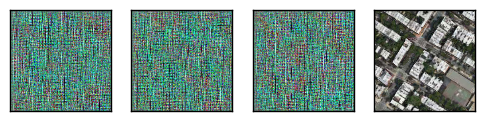

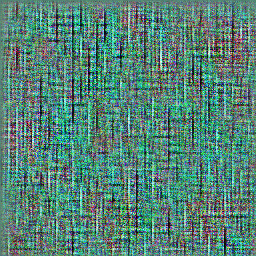

In [8]:
%matplotlib inline
def generate_sample():
    textures, real = session.run([synthetic_textures, real_textures])
    imshow_multi(list(np.clip(textures[:3], 0, 1)) + list(real[:1]))
    return to_pil(textures[0])
generate_sample()